In [1]:
from arch import arch_model
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import time
import yfinance as yf

Creation of the portfolio class

In [2]:
# create the class for a portfolio to buy, sell, show metrics, etc.
class Portfolio:
    def __init__(self, initial_cash, broker_fee=0.002):
        self.initial_cash = initial_cash # probably won't have to use this variable
        self.remaining_cash = initial_cash
        self.broker_fee = broker_fee
        self.shares_owned = 0
        self.metrics_df = pd.DataFrame(columns=['Shares Owned', 'Cash Held', 'Profits'])
    
    # lingering question: how to have this if an order has different prices in it?
    def buy(self, buy_shares, buy_price, buy_time):
        # make sure we have the money to buy the shares we want
        if self.remaining_cash - (buy_shares * buy_price) < 0:
            print('Not enough money to fill this order')
        else:
            self.remaining_cash -= ((buy_shares * buy_price) + (buy_shares * buy_price * self.broker_fee))
            self.shares_owned += buy_shares
            print(f'We are buying {buy_shares} shares at ${buy_price} per share!')

            # add this new position to a dataframe of metrics
            self.metrics_df.loc[buy_time] = {'Shares Owned': self.shares_owned, 'Cash Held': self.remaining_cash, 'Profits': self.remaining_cash - self.initial_cash}
    
    def sell(self, sell_shares, sell_price, sell_time):
        # make sure we have enough shares to sell the amount we want to sell
        if self.shares_owned < sell_shares:
            print('Not enough shares held to fill this order')
        else:
            self.remaining_cash += ((sell_shares * sell_price) - (sell_shares * sell_price * self.broker_fee))
            self.shares_owned -= sell_shares
            print(f'We are selling {sell_shares} shares at ${sell_price} per share!')
            
            # add this new position to a dataframe of metrics
            self.metrics_df.loc[sell_time] = {'Shares Owned': self.shares_owned, 'Cash Held': self.remaining_cash, 'Profits': self.remaining_cash - self.initial_cash}
    
    def show_metrics(self):
        print(self.metrics_df)
    
    def metrics_graph(self):

        # Plot y1 and y2 on the primary y-axis, and y3 on the secondary y-axis
        fig, ax1 = plt.subplots(figsize=(10, 6))  # Adjust the figure size if needed

        # Setting the x-axis
        ax1.set_xlabel('Date & Time')
        ax1.tick_params(axis='x', rotation=45)
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S')) 

        # Plot y1 and y2 on the primary y-axis
        ax1.set_ylabel('Cash in USD')
        ax1.plot(self.metrics_df.index, self.metrics_df['Cash Held'], label='Cash Held', color='tab:blue', linestyle='-')
        ax1.plot(self.metrics_df.index, self.metrics_df['Profits'], label='Profits', color='tab:green', linestyle='--')

        # Format the numbers on the y axis to be in dollars
        ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}')) 
        
        # Create a secondary y-axis for y3
        ax2 = ax1.twinx()
        ax2.set_ylabel('Number of Shares')
        ax2.plot(self.metrics_df.index, self.metrics_df['Shares Owned'], label='Shares Owned', color='tab:red', linestyle='-.')

        # Make the line at y=0 bolder
        ax1.axhline(y=0, color='black', linewidth=2)
        
        # Add title to the plot
        plt.title('Trading Metrics Over Time')
        
        # Add legend
        fig.tight_layout()
        fig.legend(loc='upper right')

        # Show plot
        plt.grid(True)
        plt.show()

Creation of our signal generation functions to see if we buy, sell, or hold

In [74]:
# linear regression helper function for our signal_gen function
def linear_reg(hist_df, category: str, show_graph=False):
    regression_metrics = {}
    
    # time series data of our prices in the specified interval
    Y = hist_df[category]

    # create X values based on the index (simple counter from 1 to n)
    X = np.arange(1, len(Y) + 1).reshape(-1, 1)

    # create a linear regression model
    model = LinearRegression()

    # fit the model to the data and predict y values
    model.fit(X, Y)
    Y_pred = model.predict(X)

    # calculate some metrics for our regression
    regression_metrics['R2'] = r2_score(Y, Y_pred)
    regression_metrics['MSE'] = mean_squared_error(Y, Y_pred)
    regression_metrics['Intercept'] = model.intercept_
    regression_metrics['Coef'] = model.coef_[0]
    
    # if we have a parameter showing that we want to see the regression graph, then create and print the graph
    if show_graph:

        # plot the time series data
        plt.scatter(Y.index, Y, color='blue', label='Data')

        # plot the regression line
        plt.plot(Y.index, Y_pred, color='red', label='Regression Line')

        # add labels and legend
        plt.xlabel('Time')
        plt.ylabel('Prices')
        plt.title('Linear Regression on Time Series Data')
        plt.legend()

        # show plot
        plt.show()
        
    return regression_metrics

# use GARCH to calculate the volatility for the GBM run
def garch_vol(prices):
    
    # set up and fit a GARCH(1,1) model
    garch_model = arch_model(prices['Close'], vol='Garch', p=3, q=3, rescale=True)
    result = garch_model.fit(disp='off')

    # forecast vol for the next 1 period
    forecast = result.forecast(horizon=1)
    forecast_volatility = np.sqrt(forecast.variance.iloc[-1])
    forecast_volatility = forecast_volatility / result.scale # bring results back to original scale
        
    return forecast_volatility

In [78]:
# geometric brownian motion function
def gbm(S0, r, sigma, sims, show_graph=False):

    # time step is 1 minute
    dt = 1/(365*24*60)

    # simulation using numpy arrays
    St = np.exp((r - sigma ** 2 / 2) * dt + sigma * np.random.normal(0, np.sqrt(dt), size=(sims, 1)).T)
    St = np.vstack([np.ones(sims), St]) # these are the y-values - start at 1 for t=0 then gbm value at t=1   
    St = S0 * St # multiply through by S0 and return the cumulative product of elements along a given simulation path (axis=0)

    # if we want to see the graph
    if show_graph:
        
        # numpy array that has sims # of 0s then sims number of 1s
        tt = np.full(shape=(sims, 2), fill_value=[0, 1]).T

        plt.plot(tt, St)
        plt.xlabel("Years $(t)$")
        plt.ylabel("Stock Price $(S_t)$")
        plt.title(f'GBM for r={r}, $S_0={S0}$, sims={sims}, $\sigma={sigma}$')
        plt.show()
    
    # this is an array of the final values
    return St[1]

# plot a line graph of stock data and then plot the next interval using geometric brownian motion
def gbm_graph_add_on(past_df, gbm_arr):
    
    # starting to create the plots
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # on our graph, show only the last 10 values before adding the GBM to end
    past_df = past_df[-10:]
    
    # plotting the past stock data information
    past_df[['Open', 'High', 'Low', 'Close']].plot(ax=ax)
    
    # plotting the generated GBM data to add on the end of the stock data
    dt_index = past_df.index[-1]
    gbm_start = np.array([past_df['Close'].iloc[-1]] * len(gbm_arr))
    gbm_addition = pd.DataFrame([gbm_start], index=[dt_index])

    # put GBM on to the end of the historical stock data
    gbm_end = pd.DataFrame([gbm_arr], index=[dt_index + pd.Timedelta(minutes=1)])
    gbm_addition = pd.concat([gbm_addition, gbm_end])
        
    # plot the GBM piece on the end of the stock data
    gbm_addition.plot(ax=ax)

    # setting up and plotting the graph
    ax.set_title('Line Plot of Stock Data with GBM Added to End')
    ax.set_xlabel('Date')
    ax.set_ylabel('Stock Price')
    ax.grid(True)
    ax.legend(title='Columns', labels=['Open', 'High', 'Low', 'Close'])
    
    plt.show()

Putting the signal generation functions together to decide on actions

In [84]:
def signal_gen(prev, past):
    
    signal_results = {'Action': 'Neutral', 'Shares': 0}
    
    # only run the regression if we have over certain amt of data points
    if len(past) > 19:
        
        # linear regression of the past stock data
        reg_results = linear_reg(past, 'Open')
        r = reg_results['Coef'] # use the slope of the linear regression as r in the GBM
        
        # run GBM for next minute
        s_start = past['Close'].iloc[-1] # get the latest closing value to use as the start of the GBM run
        vol = garch_vol(past).iloc[0]
        fin_val = gbm(s_start, r, vol, 100, show_graph=False) # run GBM and get an array of the ending values
        
        # predicted stock price is mean of the GBM run
        predicted_price = np.mean(fin_val)
        
        print(vol)
        print('start', s_start)
        print('predicted', predicted_price)
        print('pct change', 100*(predicted_price - s_start)/s_start)
        
        # plot the GBM values along with the historical stock data
        gbm_graph_add_on(past, fin_val)



        
        
    else:
        pass
    
    # choose the number of shares to buy
    signal_results['Shares'] = 1
    
    return signal_results

Actually calling the data and running the information to trade

In [56]:
msft = yf.Ticker('MSFT')

# get historical market data
today = datetime.now().strftime('%Y-%m-%d')
hist = msft.history(period='max', end=today, interval='1m') # max is 7 days when using 1 minute data

0.3858853681212005
start 401.5400085449219
predicted 401.53728227708734
pct change -0.0006789529751746613


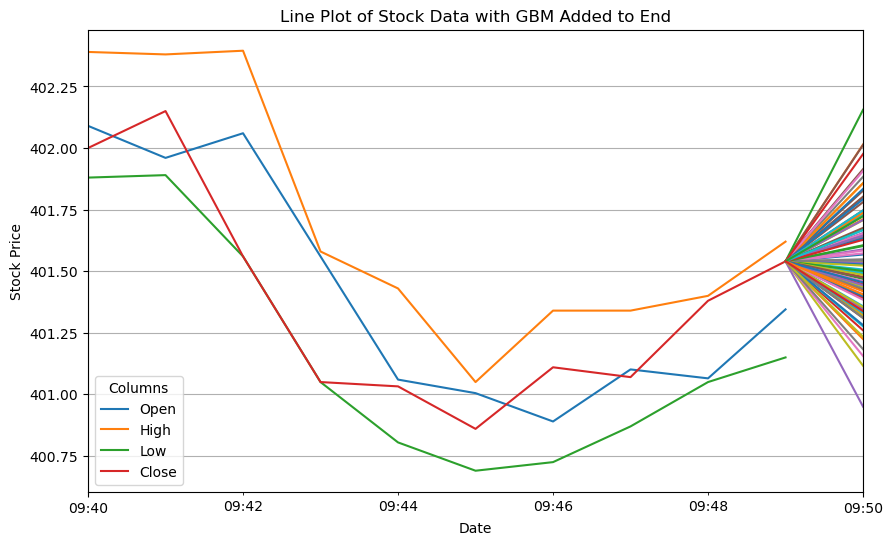

In [85]:
# instantiate portfolio with a specified amount of money
p1 = Portfolio(1_000)

# range - this will likely change to dates
range_start = 1
range_end = 21 # this is not inclusive - last data point is range_end - 1

# this would actually be running the engine - getting data and seeing if buy or sell
for i in range(range_start, range_end):
    prev_interval = hist.iloc[i-1]
    full_past = hist.iloc[:i] # slice to i because a slice is not inclusive
    
    signal = signal_gen(prev_interval, full_past)
    
    if signal['Action'] == 'Buy':
        p1.buy(signal['Shares'], prev_interval['High'], prev_interval.name)
    elif signal['Action'] == 'Sell':
        p1.sell(signal['Shares'], prev_interval['Low'], prev_interval.name)
    else: # don't buy or sell
        pass

In [ ]:
p1.show_metrics()
p1.metrics_graph()